### Ultimately, after messing with all sorts of tuning in both the ensemble gradient boost and XGBoost, I did very slightly better with the latter: ensemble Test Accuracy: 0.751 and XGB Test Accuracy: 0.757
### Not a lot, but something.  Basically, with both models, it was always a balance of finding parameters that maximized the test accuracy; it was quite easy to start overfitting, and the train/test numbers would diverge.
### I chose not to use GridSearch as a way of optimizing my configurations, preferring to get more of a feeling for what each parameter did.  Obviously utilizing tools like it will be my long-term solution.

In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

### Default setup below

In [2]:
df = pd.read_csv("Euro_happiness.csv").dropna()

# Definine outcome and predictors.
# Set our outcome to 0 and 1.
y = df['partner'] - 1
X = df.loc[:, ~df.columns.isin(['partner', 'cntry', 'idno'])]

# Make the categorical variable 'country' into dummies.
X = pd.concat([X, pd.get_dummies(df['cntry'])], axis=1)

# Create training and test sets.
offset = int(X.shape[0] * 0.9)

# Put 90% of the data in the training set.
X_train, y_train = X[:offset], y[:offset]

# And put 10% in the test set.
X_test, y_test = X[offset:], y[offset:]

In [3]:
# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))
print('\nTraining Accuracy:', clf.score(X_train, y_train))
print('Test Accuracy:', clf.score(X_test, y_test))

Training set:
Percent Type I errors: 0.04650845608292417
Percent Type II errors: 0.17607746863066012

Test set:
Percent Type I errors: 0.06257668711656442
Percent Type II errors: 0.18527607361963191

Training Accuracy: 0.7774140752864157
Test Accuracy: 0.7521472392638037


In [4]:
params = {'n_estimators': 390,
          'max_depth': 2,
          'loss': 'deviance',
          'subsample':0.95}

clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))
print('\nTraining Accuracy:', clf.score(X_train, y_train))
print('Test Accuracy:', clf.score(X_test, y_test))

Training set:
Percent Type I errors: 0.04678123295144572
Percent Type II errors: 0.17703218767048554

Test set:
Percent Type I errors: 0.0638036809815951
Percent Type II errors: 0.19386503067484662

Training Accuracy: 0.7761865793780688
Test Accuracy: 0.7423312883435583


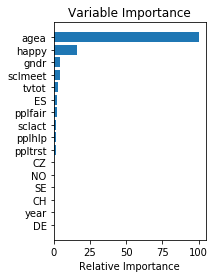

In [5]:
feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

## Let's see how XGBoost does

In [6]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [7]:
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

### Just out of the box numbers

In [8]:
predictions = model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 73.99%


In [9]:
print(model, '\n')

predict_train = model.predict(X_train)
predict_test = model.predict(X_test)

table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))
print('\nTraining Accuracy:', model.score(X_train, y_train))
print('Test Accuracy:', model.score(X_test, y_test))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1) 

Training set:
Percent Type I errors: 0.040780141843971635
Percent Type II errors: 0.1869885433715221

Test set:
Percent Type I errors: 0.053987730061349694
Percent Type II errors: 0.20613496932515338

Training Accuracy: 0.7722313147845062
Test Accuracy: 0.7398773006134969


### Looks like it beats the other once it's tuned up a bit

In [10]:
params = {'n_estimators': 300,
          'max_depth': 3,
          'subsample':1, 
          'learning_rate':0.1,
          'colsample_bytree':0.28,
          'colsample_bylevel':1}

model = XGBClassifier(**params)
model.fit(X_train, y_train)

predict_train = model.predict(X_train)
predict_test = model.predict(X_test)

table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))
print('\nTraining Accuracy:', model.score(X_train, y_train))
print('Test Accuracy:', model.score(X_test, y_test))

Training set:
Percent Type I errors: 0.04187124931805783
Percent Type II errors: 0.18303327877795963

Test set:
Percent Type I errors: 0.06134969325153374
Percent Type II errors: 0.18159509202453988

Training Accuracy: 0.7750954719039825
Test Accuracy: 0.7570552147239263
